In [38]:
import numpy as np # линейная алгебра
import pandas as pd # обработка данных
import collections #модуль который поставляется с несколькими типами данных
import re #для работы с регулярными выражениями
import nltk #лучшая библиотека для обработки естественного языка
import string
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer #обучаем компьютер чувствам
nltk.downloader.download('vader_lexicon') #анализ настроения

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split #данным инструментом пользуются
#для разделения датасета на данные для обучения и тестирования

from category_encoders import  OneHotEncoder, OrdinalEncoder
 #нужен будет при кодировании каких-то категориальных признаков в числовой

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Telli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
#pip freeze requirements.txt — команда, которая позволяет создать текстовый документ
#в котором перечислены все установленные и необходимые для работы Python приложения программные пакеты

#Подгрузим наши данные из соревнования
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн pip install -r requirements.txt

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [42]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [43]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # покажем где наш тренировочный датасет
df_test['sample'] = 0 # покажем ту часть, что с тестовым 
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем тестовый и тренировочный датасет
hotels

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


In [44]:
#кодировать название всех отелей не имеет смысла, как можно закодировать название топовых отелей, полагаясь на average_score
hotels_names = hotels.groupby('hotel_name')['average_score'].agg(['mean', 'count']) #тут передадим счетчик и вычислитель среднего для рейтингов
#маску создадим дабы показать что ищем со средним рейтингом больше 9, в количестве 100 отелей:
mask = (hotels_names['mean'] >= 9.0)&(hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]
print("А вот и лучшие по отзывам отели:")
display(hotels_top)

#добавим новый признак во внутрь нашего датасета
hotels['hotel_category'] = hotels['hotel_name'].apply(lambda x: x if x in hotels_top.index else 'other') #применим с однострочным кодом к столбцу с названиями
#вышевоспроизведенные нами манипуляции и вуаля, создали признак где Топовый будут отмечаться соответственным рейтингом, а не топовые "другие"

# применим порядковое кодирование:
ord_encoder = OrdinalEncoder()
hotels['hotel_category'] = hotels['hotel_category'].astype('category')
hotels_bin = ord_encoder.fit_transform(hotels['hotel_category'])
hotels = pd.concat([hotels, hotels_bin], axis=1)

# удалим исходный столбец
col = hotels.columns.tolist()

hotels.set_axis(col, axis=1, inplace=True)
hotels.drop('hotel_category', axis=1, inplace=True)

А вот и лучшие по отзывам отели:


,mean,count
hotel_name,,
41,9.6,103
Acad mie H tel Saint Germain,9.0,255
Alma Barcelona GL,9.2,179
Amba Hotel Charing Cross,9.3,785
Ambassade Hotel,9.3,551
...,...,...
Waldorf Astoria Amsterdam,9.5,142
art otel Amsterdam,9.0,790
citizenM London Bankside,9.1,1517


In [45]:
#Закодируем признак "адрес отеля"
adresses = pd.Series(hotels['hotel_address'].unique())
countries = adresses.apply(lambda x: x.split()[-1])
countries = countries.apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

cities = adresses.apply(lambda x: x.split()[-2])
cities = cities.apply(lambda x: 'London' if x=='United' else x)

adresses = pd.DataFrame( {'adress' : adresses, 'country': countries, 'city': cities})

display(adresses.groupby(['country','city']).count())

#добавим в наши данные страну отеля, дабы в дальнейшем иденфицировать национальность

hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

#добавив признак, нужно еще и закодировать информацию о стране
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes

#давайте добавим признак города тоже в наш датасет для удобства
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: 'London' if x.split()[-2] == 'United' else x.split()[-2])

#добавив признак, нужно еще и закодировать информацию о городе
hotels['hotel_city'] = hotels['hotel_city'].astype('category')
hotels['hotel_city_code'] = hotels['hotel_city'].cat.codes


,,adress
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


In [46]:
# посмотрим, как распределяются отели по странам
hotels_countries = hotels.groupby('hotel_country')['hotel_name'].count()
fig = px.choropleth(
    locations=hotels_countries.index,
    locationmode = "country names",
    scope='europe',
    color=np.log(hotels_countries.values),
    color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

In [47]:
#из строки с адресом извлечём почтовый индекс непосредственно с функцией

def get_postcode(addresses):
    address_list = addresses.split()
    postcode_place = {
        'Kingdom': -4, #как правило почтовый индекс идет с конца после названия страны и города. Так как United Kingdom London следовательно на 4 месте
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    
    postcode = str(address_list[postcode_place[address_list[-1]]])
    
    if address_list[-1] == 'Kingdom' and postcode[-1].isalpha():
        return postcode[:-1]
    else:
        return postcode

# добавим почтовый индекс отеля как идентификатор района:
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_postcode)

In [48]:
without_coordinates = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts())
print(f'Количество отелей с отсутствующими координатами: {without_coordinates}')

Количество отелей с отсутствующими координатами: 17


In [49]:
# вычисляем средние значения координат для каждого района:
pivot_coor = pd.pivot_table(
    hotels, 
    index='hotel_postcode', 
    values=['lat', 'lng'], 
    dropna=True, 
    aggfunc='mean')

hotels['lat'] = hotels.apply(
    lambda row: pivot_coor['lat'][row['hotel_postcode']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: pivot_coor['lng'][row['hotel_postcode']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

In [50]:
#теперь протестим остались ли отели с отсуствующими координатами, после вышепроизведенныз манипуляций:
wth_co_test = len(hotels[hotels.isnull().any(1)]['hotel_name'].value_counts()) 

In [51]:
#теперь протестим остались ли отели с отсуствующими координатами, после вышепроизведенныз манипуляций:
wth_co_test = len(hotels[hotels.isna()]['hotel_name'].value_counts()) 
wth_co_test

0

In [52]:
#страна рецензента
hotels.head(1) #грузим датасет, чтобы напомнить себе о имеющихся данных
#Метод strip() возвращает копию строки, в которой все символы были удалены с начала и конца строки
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
nationality_count = len(hotels['reviewer_nationality'].value_counts())
print(f'Представители {nationality_count} стран являются рецензентами')

#проанализируем топ 30 стран
print('\nСамые популярные страны:')
print(list(hotels['reviewer_nationality'].value_counts(ascending=False)[:40].index))

#выделим основные англоязычные страны:
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia', 
                'Canada', 
                'New Zealand']

hotels['reviewer_en'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in english_list else 0)

# выделим мусульманские страны ближневосточного региона:
muslim_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar', 
               'Oman']
hotels['reviewer_msl_est'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x in muslim_list else 0)

# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
hotels['reviewer_nationality_cat'] = hotels['reviewer_nationality'].cat.codes

Представители 227 стран являются рецензентами

Самые популярные страны:
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'India', 'Greece', 'China', 'Sweden', 'New Zealand', 'Singapore', 'Hong Kong', 'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic', 'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal', 'Finland']


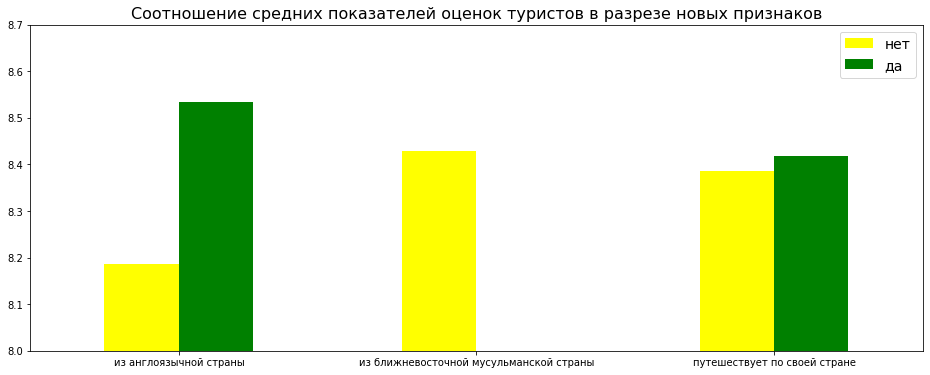

In [53]:
#увидем визуально соотношений наших новых признаков по отношению к отзывам
mask = hotels['sample'] == 1
pivot_en = hotels[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_n_est = hotels[mask].groupby('reviewer_msl_est')['reviewer_score'].mean()
pivot_resident = hotels[mask].groupby('reviewer_resident')['reviewer_score'].mean()

pivot = pd.DataFrame({
    'из англоязычной страны': pivot_en,
    'из ближневосточной мусульманской страны': pivot_n_est,
    'путешествует по своей стране': pivot_resident 
}).T

# строим диаграмму:
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    ax=ax2, 
    kind='bar', 
    color=['yellow', 'green'], 
    rot=0)
ax2.set_title(
    'Соотношение средних показателей оценок туристов в разрезе новых признаков', size=16)
ax2.legend(['нет', 'да'], loc='upper right', fontsize=14)

plt.ylim(8, 8.7);


In [54]:
# Добавляем признак давности размещения отзыва и признаки по дням, неделям и месяцам
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')
hotels['review_month'] = hotels['review_date'].dt.month.astype(int)
hotels['days_since_review'] = ((hotels['review_date'].max() - hotels['review_date'])/np.timedelta64(1,'D')).astype(int) #находим разницу в днях 
hotels['review_day'] = hotels['review_date'].dt.day.astype(int)
hotels['review_weekday'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels = hotels.drop(['review_date'], axis=1)

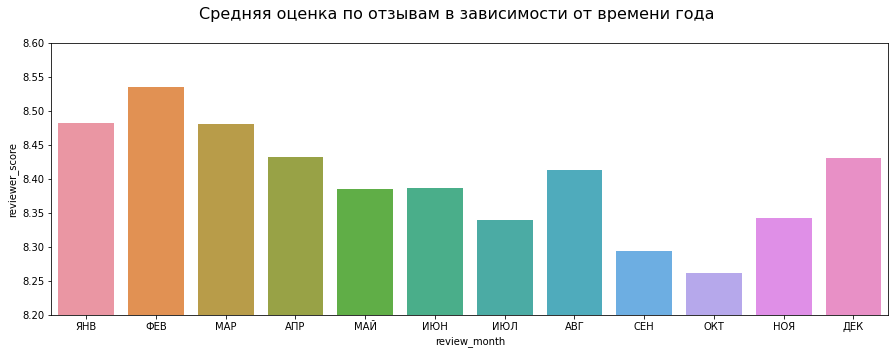

In [55]:
mask = hotels['sample'] == 1
pivot_month = hotels[mask][['review_month', 'reviewer_score']].groupby('review_month').mean()
fig3, ax3 = plt.subplots(figsize=(15, 5))
plt.suptitle('Средняя оценка по отзывам в зависимости от времени года', size=16)
bar_month = sns.barplot(
    x=pivot_month.index, 
    y=pivot_month['reviewer_score'])
ax3.set_xticklabels([
    'ЯНВ', 'ФЕВ', 'МАР', 'АПР', 'MAЙ', 'ИЮН', 
    'ИЮЛ', 'АВГ', 'СЕН', 'ОКТ', 'НОЯ', 'ДЕК'])

plt.ylim(8.2, 8.6);

In [56]:
hotels.tags = hotels.tags.apply(lambda x: x[3:-3].split(" ', ' "))

In [57]:
#Смотрим на топ 20 тегов
top_tags = list(hotels.tags.explode().value_counts().index)[:20]
print(top_tags)

['Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip', 'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room', 'Standard Double Room', 'Superior Double Room', 'Family with older children', 'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights', 'Standard Double or Twin Room', 'Classic Double Room']


In [58]:
# закодируем признак tags
for tag in top_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)
    
hotels = hotels.drop(['tags'], axis=1)
hotels.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Всего слов в отзывах каждого пользователя
hotels['total_words'] = hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts']
# Доли положительных и отрицательных частей
hotels['positive_rate'] = round(hotels['review_total_positive_word_counts'] / hotels['total_words'] * 100)
hotels['negative_rate'] = round(hotels['review_total_negative_word_counts'] / hotels['total_words'] * 100)

Text(0.5, 1.0, 'Распределение % отриц. отзывов')

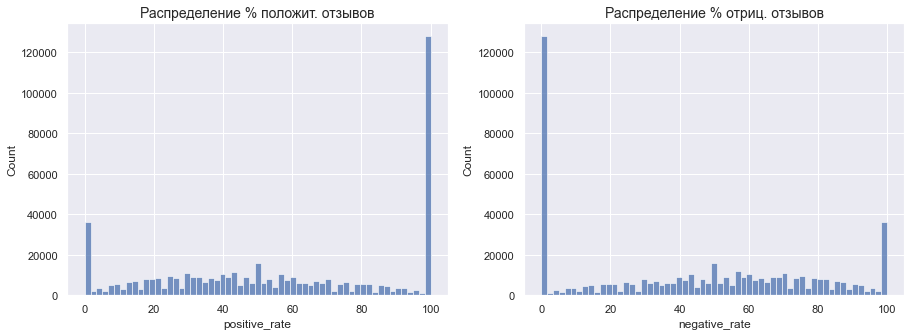

In [60]:
sns.set_theme()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
sns.histplot(data=hotels, x='positive_rate', ax=ax[0])
sns.histplot(data=hotels, x='negative_rate', ax=ax[1])
ax[0].set_title('Распределение % положит. отзывов', fontdict={'size': 14})
ax[1].set_title('Распределение % отриц. отзывов', fontdict={'size': 14})

In [61]:
values = {
    'positive_rate': hotels['positive_rate'].median(),
    'negative_rate': hotels['negative_rate'].median(),
}

# заполняем пропуски в соответствии с заявленным словарем
hotels = hotels.fillna(values)

In [62]:
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'average_score',
       'hotel_name', 'reviewer_nationality', 'negative_review',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'positive_review', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'hotel_country',
       'hotel_country_code', 'hotel_city', 'hotel_city_code', 'hotel_postcode',
       'reviewer_en', 'reviewer_msl_est', 'reviewer_resident',
       'reviewer_nationality_cat', 'review_month', 'review_day',
       'review_weekday', 'Leisure trip', 'Submitted from a mobile device',
       'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler',
       'Stayed 3 nights', 'Business trip', 'Group',
       'Family with young children', 'Stayed 4 nights', 'Double Room',
       'Standard Double Room', 'Superior Double Room',
       'Family with older children', 'Deluxe Double Room'

In [63]:
hotels['negative_review'].value_counts()[:10]


No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
 None             984
                  849
 N a              509
 Breakfast        407
 Small room       373
Name: negative_review, dtype: int64

In [65]:
sent_analyzer = SentimentIntensityAnalyzer()

# проводим анализ отзывов
hotels['negative_sent_review'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['positive_sent_review'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываем результаты в основной датафрейм в виде отдельных признаков
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,negative_sent_review,positive_sent_review,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908


In [66]:
hotels['no_neg'] = 0
hotels['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

no_pos_list = ['no positive', 'nothing']

hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

hotels['positive_review'].value_counts()[:10]

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [67]:
hotels['negative_review'].value_counts()[:10]


                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: negative_review, dtype: int64

In [68]:
hotels_copy = hotels.copy()

In [69]:
object_columns = [x for x in hotels.columns if hotels[x].dtypes == 'object']
print(object_columns)
hotels_copy.drop(object_columns, axis = 1, inplace=True)

['hotel_address', 'hotel_name', 'negative_review', 'positive_review', 'hotel_postcode', 'negative_sent_review', 'positive_sent_review']


In [70]:
hotels_copy.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'hotel_country',
       'hotel_country_code', 'hotel_city', 'hotel_city_code', 'reviewer_en',
       'reviewer_msl_est', 'reviewer_resident', 'reviewer_nationality_cat',
       'review_month', 'review_day', 'review_weekday', 'Leisure trip',
       'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
       'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
       'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
       'Standard Double Room', 'Superior Double Room',
       'Family with older children', 'Deluxe Double Room',
       'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'Classic Do

In [71]:
cols_to_del = ['additional_number_of_scoring', # корреляция с другим признаком
 'reviewer_nationality', # текстовые
 'days_since_review',
                'hotel_city', 'review_weekday', 'review_month'  # категориальные
                ]

hotels_copy = hotels_copy.drop(cols_to_del, axis=1)

In [72]:
# Нормализация числовых признаков
from sklearn import preprocessing

cols_num = ['average_score', 'review_total_positive_word_counts', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'total_words',
            'lat', 'lng' ] # числовые признаки для нормализации

mm_scaler = preprocessing.MinMaxScaler()
data_num = hotels_copy[cols_num].copy() # скопируем эти данные

data_num_mm = mm_scaler.fit_transform(data_num)
data_num_mm = pd.DataFrame(data_num_mm, columns=cols_num)
 

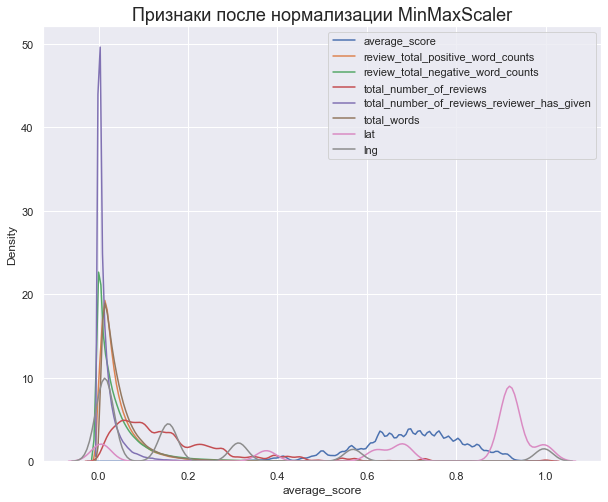

In [73]:
# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Признаки после нормализации MinMaxScaler', fontdict={'fontsize': 18})

for col in cols_num:
    sns.kdeplot(data_num_mm[col], ax=ax1)

plt.legend(cols_num)

In [74]:
columns_to_delete = ['hotel_country']
hotels_copy.drop(columns_to_delete, axis=1, inplace=True)
hotels_copy.columns

Index(['average_score', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample',
       'reviewer_score', 'hotel_country_code', 'hotel_city_code',
       'reviewer_en', 'reviewer_msl_est', 'reviewer_resident',
       'reviewer_nationality_cat', 'review_day', 'Leisure trip',
       'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
       'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
       'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
       'Standard Double Room', 'Superior Double Room',
       'Family with older children', 'Deluxe Double Room',
       'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'Classic Double Room', 'total_words',
       'positive_rate', 'negative_rate', 'n_neg', 'n_neu', 'n_pos',
       'n_compound', 'p_neg', 'p_neu', 'p_pos', 'p_compound',

In [75]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews', 
            'positive_rate', 'negative_rate' ]

cat_cols = list(set(hotels_copy.columns) - set(num_cols) - {'reviewer_score', 'sample'})
 

<AxesSubplot:>

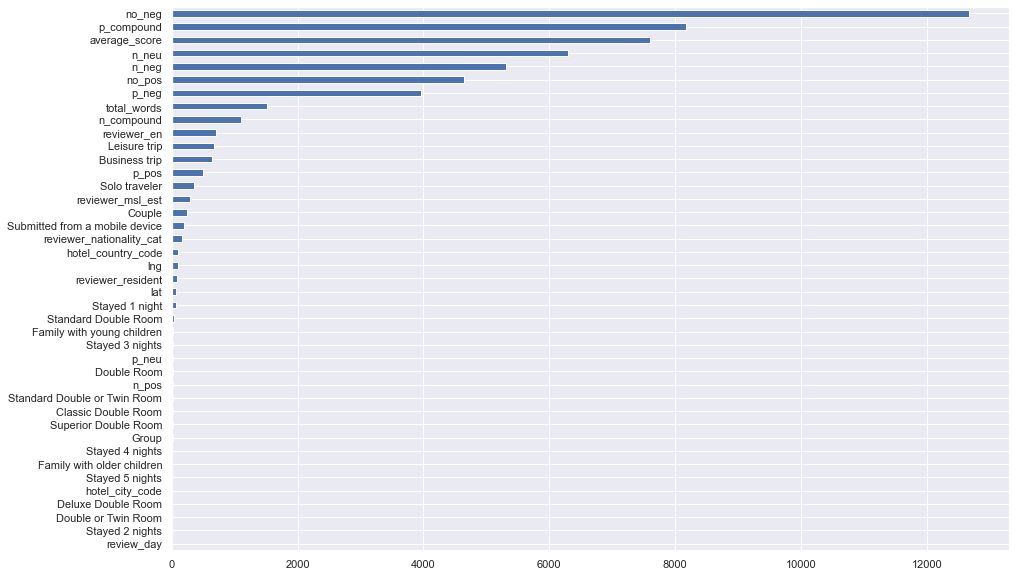

In [76]:
# Using ANOVA test to discover relations between category features and target variable
from sklearn.feature_selection import f_classif
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values.astype('int')
X = hotels_copy.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15,10)
# imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat = pd.Series(f_classif(X, y)[0], index = cat_cols) # v.19
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

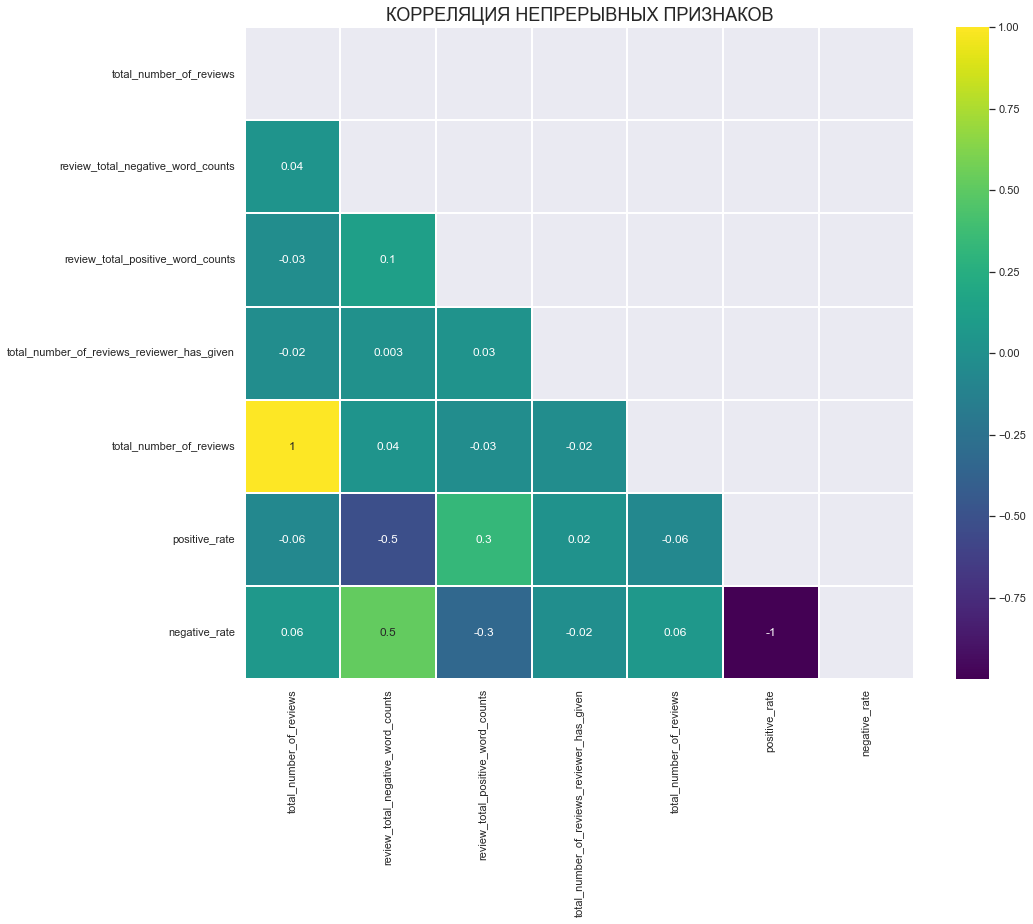

In [77]:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = hotels_copy[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()
show_corr_heatmap(num_cols, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson');

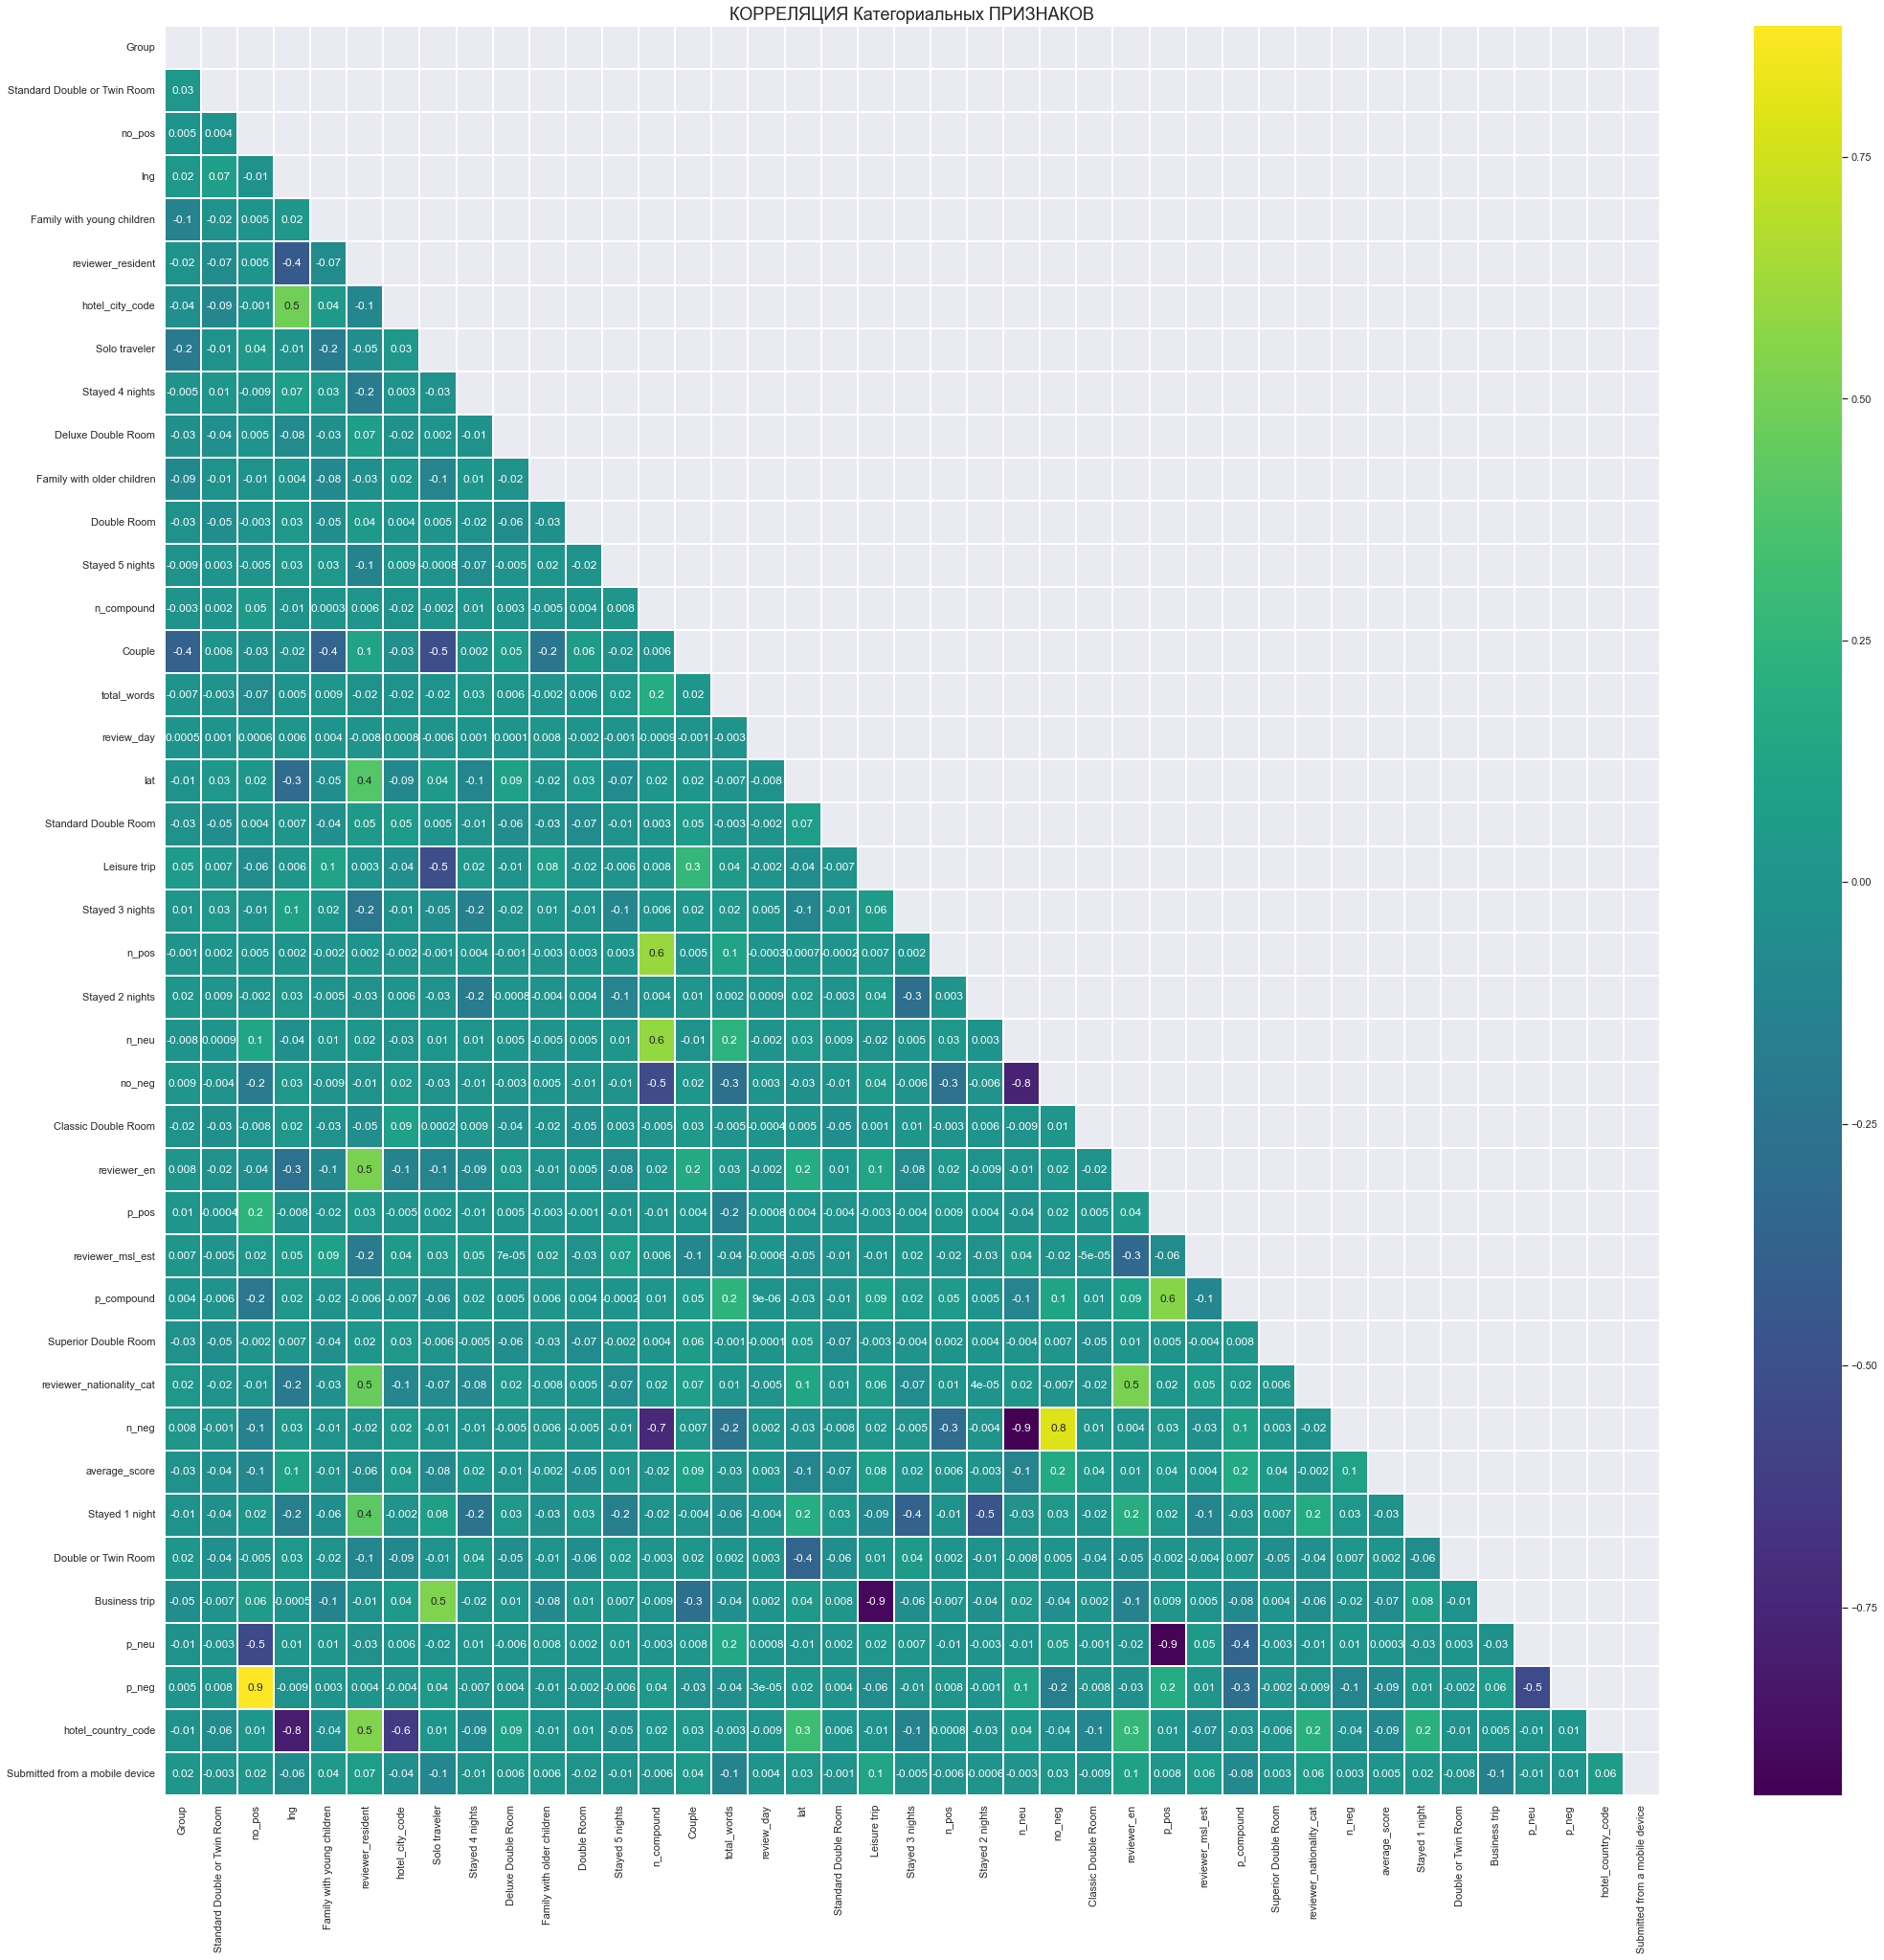

In [78]:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(35, 34))
    corr = hotels_copy[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()
show_corr_heatmap(cat_cols, 'КОРРЕЛЯЦИЯ Категориальных ПРИЗНАКОВ', method='pearson');

In [79]:
corr_matrix = hotels_copy.drop(['sample'], axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
display(to_drop)

hotels_copy.drop(to_drop, axis=1, inplace=True)

['hotel_country_code',
 'Business trip',
 'total_words',
 'negative_rate',
 'n_neu',
 'p_pos',
 'no_pos']

In [80]:
# теперь выделим тестовую часть
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [81]:
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape
# создаём модель
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
X_train.fillna(X_train.mean(), inplace=True)

In [86]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


In [88]:
# Mean Absolute Percentage Error (MAPE) function

def mean_absolute_percentage_error(y_true, y_pred):
    """Function to calculate Mean Absolute Percentage Error between two vectors."""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [90]:
# Comparing the predicted values (y_pred) with the real ones (y_test), and assessing the average difference
# The Mean Absolute Error metric shows the average deviation of the predicted values from the actual ones.
# The Mean Absolute Percentage Error metric shows the average ratio of deviation of the predicted values from the actual ones.
from sklearn import metrics # model accuracy estimation tools
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8688450522011519
MAPE: 12.401862851162168


<AxesSubplot:>

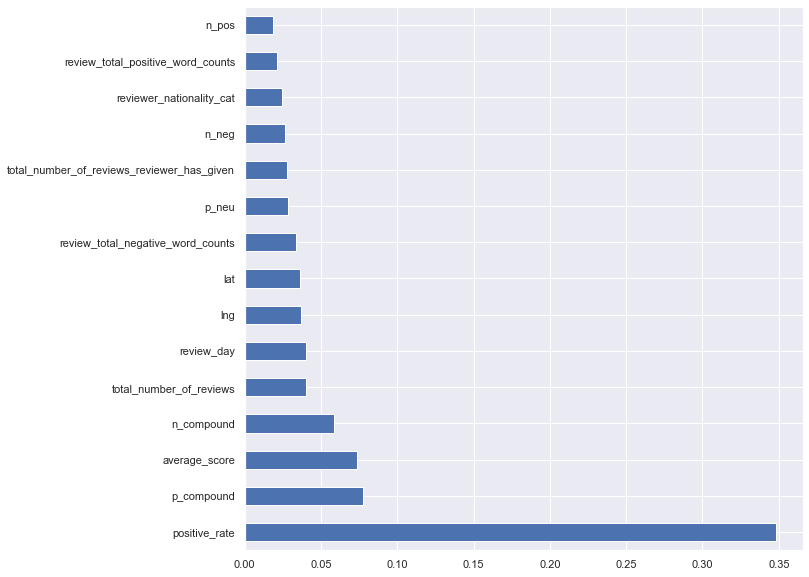

In [91]:
# Displaying the most important features of the trained model

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [92]:
test_data.sample(3)


,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,hotel_city_code,reviewer_en,...,Standard Double or Twin Room,Classic Double Room,positive_rate,n_neg,n_pos,n_compound,p_neg,p_neu,p_compound,no_neg
2255,8.9,5,2695,13,2,41.384829,2.175128,0.0,1,1,...,0,0,72.0,0.0,0.000,0.0000,0.0,0.199,0.9641,1
67932,6.4,15,2275,26,1,51.522052,-0.132414,0.0,2,1,...,0,0,63.0,0.0,0.161,0.3182,0.0,0.559,0.9324,0
7810,8.5,0,2901,3,1,45.457465,9.191914,0.0,3,0,...,0,0,100.0,1.0,0.000,-0.7096,0.0,1.000,0.0000,1


In [93]:
test_data = test_data.drop(['reviewer_score'], axis=1)


In [94]:
sample_submission.head(2)


,reviewer_score,id
0,1,488440
1,10,274649


In [95]:
predict_submission = model.predict(test_data)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.7s finished


In [96]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_v33.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.557,488440
1,7.462,274649
2,7.945,374688
3,9.726,404352
4,9.637,451596
5,9.180,302161
6,7.441,317079
7,7.552,13963
8,8.275,159785
9,7.341,195089
